# MVO

## Few helper functions

In [323]:
import scipy.optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.ticker import PercentFormatter

def port_mean_var(W, R, C):
    mean = sum(R * W)
    var = np.dot(np.dot(W, C), W)
    return mean, var

def normalize_array(arr):
    min_value = np.min(arr)
    if min_value < 0: 
        arr = arr - min_value 
    arr_sum = np.sum(arr)
    normalized_arr = arr / arr_sum
    return normalized_arr

def solve_weights(R, C, rf):
    def fitness(W, C):
        return np.dot(W.T, np.dot(C, W))
    
    n = len(R)
    W = normalize_array((R - rf) / np.sqrt(np.diagonal(C)))
    b_ = [(0., 1.) for _ in range(n)]  
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.},  
          {'type': 'ineq', 'fun': lambda W: np.dot(W, R) - rf})

    optimized = scipy.optimize.minimize(fitness, W, (C), method='SLSQP', 
                                        constraints=c_, bounds=b_, 
                                        options={'maxiter': 1000, 'ftol': 1e-9})
    if not optimized.success: 
        sum_w = np.sum(optimized.x)
        R_formatted = ', '.join(f'{x:.4f}' for x in R)
        W_i_formatted = ', '.join(f'{x:.4f}' for x in W)
        sharpe = (R - rf) / np.sqrt(np.diagonal(C))
        sharpe_formatted = ', '.join(f'{x:.4f}' for x in sharpe)
        W_f_formatted = ', '.join(f'{x:.4f}' for x in optimized.x)
        vol = np.sqrt(np.diagonal(C))
        vol_formatted = ', '.join(f'{x:.4f}' for x in vol)

        print(f"SUM_W: {sum_w:.4f}")
        print(f"R: [{R_formatted}]")
        print(f"V: [{vol_formatted}]")
        print(f"Sharpe: {sharpe_formatted}")
        print(f"W_i: [{W_i_formatted}]")
        print(f"W_f: [{W_f_formatted}]")
        print(f"var: {var:.4f} | mean: {mean:.4f} | rf: {rf:.4f}")
        print("===========================================================")
        mean, var = port_mean_var(W, R, C)
        return W, 1, mean, var 
    else:
        mean, var = port_mean_var(optimized.x, R, C)
        # if optimized.x[0] > 0.95:
        #     sum_w = np.sum(optimized.x)
        #     R_formatted = ', '.join(f'{x:.4f}' for x in R)
        #     W_i_formatted = ', '.join(f'{x:.4f}' for x in W)
        #     sharpe = (R - rf) / np.sqrt(np.diagonal(C))
        #     sharpe_formatted = ', '.join(f'{x:.4f}' for x in sharpe)
        #     W_f_formatted = ', '.join(f'{x:.4f}' for x in optimized.x)
        #     vol = np.sqrt(np.diagonal(C))
        #     vol_formatted = ', '.join(f'{x:.4f}' for x in vol)

        #     print(f"SUM_W: {sum_w:.4f}")
        #     print(f"R: [{R_formatted}]")
        #     print(f"V: [{vol_formatted}]")
        #     print(f"Sharpe: {sharpe_formatted}")
        #     print(f"W_i: [{W_i_formatted}]")
        #     print(f"W_f: [{W_f_formatted}]")
        #     print(f"var: {var:.4f} | mean: {mean:.4f} | rf: {rf:.4f}")
        #     print("===========================================================")
        return optimized.x, 0, mean, var

## Load Historical Prices

In [324]:
def load_data():
    symbols = ['IMA-S', 'IMA-B', 'IRF-M', 'IHFA', 'Ibovespa', 'S&P 500']
    prices_out = []
    dataframe = pd.read_csv('G:/My Drive/Poli-USP/TCC/Codes/MVO/Data/AA_indexes.csv', 
                                index_col=['Data'],
                                sep=';', decimal=',', thousands=" ",
                                parse_dates=['Data'])
    for s in symbols:
        prices = list(dataframe.loc['2014-01-01':'2023-12-31', s])
        prices_out.append(prices)
    dates = dataframe.loc['2014-01-01':'2023-12-31'].index
    return dates, symbols, prices_out

dates, names, prices = load_data()

## Estimate assets hitorical return and covariances

In [325]:
def assets_historical_returns_and_covariances(prices):  # each row of prices is an asset
    prices = np.matrix(prices) 
    rows, cols = prices.shape
    
    # create matrix of historical returns
    returns = np.empty([rows, cols - 1])
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1

    expreturns = np.array([]) 
    expreturns = np.append(expreturns, (prices[:, -1] / prices[:, 0])) - 1
    covars = np.cov(returns)
    
    return expreturns, covars

def percentage(x): # where x is an array with a list or a matrix
    if len(x.shape) == 2:
        x = np.round(np.multiply(x, 100), 2)
        perc_x = np.empty(x.shape, dtype=object)
        for r in range(x.shape[0]):
            for c in range(x.shape[1]):
                perc_x[r, c] = str(x[r, c]) + '%'
    else:
        perc_x = np.round(np.multiply(x, 100), 2)
        perc_x = [str(value) + '%' for value in perc_x]
    return perc_x

# R, C = assets_historical_returns_and_covariances(prices)
# rf = 0.0928  # Risk-free rate
# vol = np.sqrt(np.diagonal(C))
# display(pd.DataFrame({'Return': percentage(R)}, index=names).T)
# display(pd.DataFrame({'Volatility': percentage(vol)}, index=names).T)
# display(pd.DataFrame(percentage(C), index=names, columns=names))
# res1 = optimize_frontier(R, C, rf)
# display_assets(names, R, C, color='blue')
# plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
# display(pd.DataFrame({'Weight': res1.W}, index=names).T)

## Mean-Variance Optimization

In [326]:
# Get the risk-free rate for a desired window
def risk_free_IMA_B(IMA_B, i, window_size=50):
    rf = IMA_B[i+window_size-1] / IMA_B[i] - 1
    return rf

window_size = 2200
reduction = 0
errors = 0
rows = len(prices[0])-window_size-reduction; cols = len(prices)
weights = np.empty([rows, cols])
mean = np.empty([rows]); variance = np.empty([rows])

# Get the asset allocation for each window
for i in tqdm(range(rows)):
    rf = risk_free_IMA_B(prices[0], i, window_size)
    truncated_prices = [index[i:i+window_size] for index in prices]
    R, C = assets_historical_returns_and_covariances(truncated_prices)
    weights[i], err, mean[i], variance[i] = solve_weights(R, C, rf)
    errors += err 

print("Errors: ", errors)
print("# of days: ", rows)

  0%|          | 0/308 [00:00<?, ?it/s]

Errors:  0
# of days:  308


### Weights Distribution Over Time

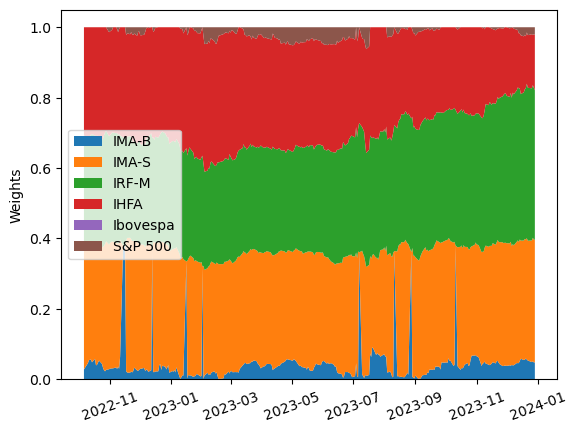

In [327]:
trimmed_dates = dates[window_size+reduction:]

# Plotting the stacked area plot
fig, ax = plt.subplots()
ax.stackplot(trimmed_dates, weights.T, labels=['IMA-B', 'IMA-S', 'IRF-M', 'IHFA', 'Ibovespa', 'S&P 500'])

# Add legend, titles, and labels
ax.legend(loc='center left')
plt.xticks(rotation=20)
plt.ylabel('Weights')

# Show the plot
plt.show()

### Daily Portfolio Returns and Volatility

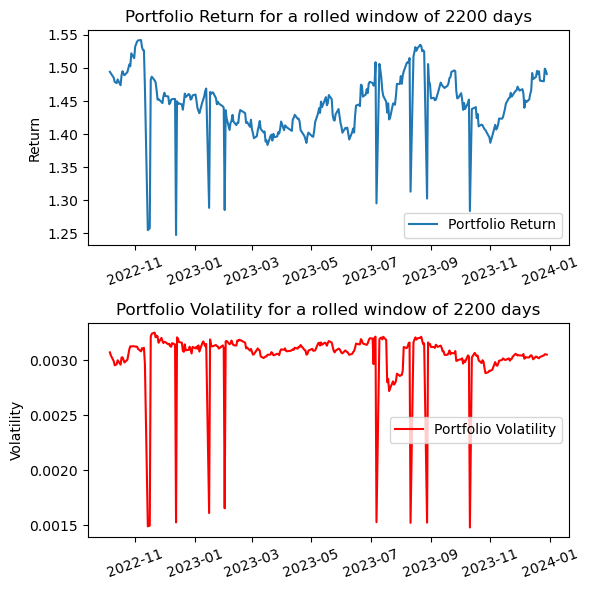

In [328]:
# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plotting port_return on the first subplot
axs[0].plot(trimmed_dates, mean, label='Portfolio Return')
axs[0].set_ylabel('Return')
axs[0].set_title(f'Portfolio Return for a rolled window of {window_size} days')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=20)

# Plotting port_vol on the second subplot
axs[1].plot(trimmed_dates, np.sqrt(variance), label='Portfolio Volatility', color='red')
axs[1].set_ylabel('Volatility')
axs[1].set_title(f'Portfolio Volatility for a rolled window of {window_size} days')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=20)

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [329]:
for i in range(mean.shape[0]):
    if mean[i] < 0.005:
        print("Negative mean: ", mean[i])
        print("Date: ", trimmed_dates[i])

### Portfolio Historical Return

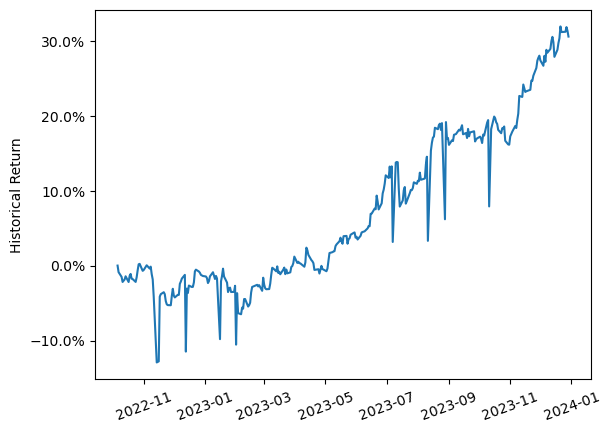

In [330]:
def portfolio_return(prices, weights):
    prices = np.matrix(prices) 
    rows, _ = prices.T.shape
    returns = np.empty([rows, 1])
    for i in range(rows):
        returns[i] = np.dot(prices.T[i], weights[i])
    return returns

trimmed_prices = [lst[window_size+reduction:] for lst in prices]
historical_return = portfolio_return(trimmed_prices, weights)
historical_return = historical_return / historical_return[0] - 1

# Plotting historical returns
fig, ax = plt.subplots()
ax.plot(trimmed_dates, historical_return)

ax.set_ylabel('Historical Return')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=20)
plt.show()